<a href="https://colab.research.google.com/github/atayino/fortran_study_202008xx/blob/master/TFUG_TFP%E3%81%AE%E5%9F%BA%E7%A4%8E_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 本セッションの目的
確率的プログラミング言語として現状、実務で最も使われているのはStanとPyMC3でしょう。これらの言語については公式ドキュメントが充実しており、書籍も複数出版されています。  
一方、TensorFlow Probabaility(TFP)はドキュメントが整備されつつあるものの、ネット上の情報（特に日本語のもの）はまだまだ少ないです。当セッションではTFPを用いる上で知っておくべき基本概念や簡単なモデリングの実例を紹介します。　　
<br><br>
## Table of contents
* TFPの基本概念
    * Distribution
    * Bijector
    * shapeについて
    * JointDistribution
    * MCMCによる近似推論

* 簡単なモデリングの例
    * 変化点検知
    * 混合正規分布



# 新しいセクション

In [ ]:
#@title Import packages
!pip install arviz # MCMCの結果の可視化に利用
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

print(f'TF version {tf.__version__}')
print(f'TFP version {tfp.__version__}')

%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')
sns.set_style('darkgrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TF version 2.3.0
TFP version 0.11.0


In [ ]:
#@title Utility functions
def format_trace(states, var_name, chain_dim=None):
    if chain_dim is None:
        # chainが１つだと明示するためaxisを追加
        trace = {k: v[tf.newaxis].numpy() for k, v in zip(var_name, states)}
    else:
        # axis0がchainの次元になるようにする
        trace = {k: np.swapaxes(v.numpy(), chain_dim, 0) for k, v in zip(var_name, states)}
    # from_tfpもあるが、実行するとeager_executionがオフにされてしまうなど現状使いづらいので、from_dictを用いている
    return az.from_dict(trace)


def init_random(shape, n_chains=1, r=2):
    """Stanにならい、Uniform(-2, 2)で初期化する
    """
    if n_chains == 1:
        return tf.random.uniform(shape, -r, r)
    else:
        return tf.random.uniform([n_chains,] + shape, -r, r)

# TFPの基本概念

## Distribution
まずは統計モデルを構築する際の「部品」となる確率分布についてです。tfp.distributionモジュールには数多くの確率分布が実装されています。正規分布、ポアソン分布などの基本的な確率分布に加え、線形ガウス状態空間モデルやPixelCNNなど複数の確率分布を組み合わせたモデルを実装した確率分布もあります。

In [ ]:
# 標準正規分布
normal = tfd.Normal(loc=0., scale=1.)
print(normal)

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


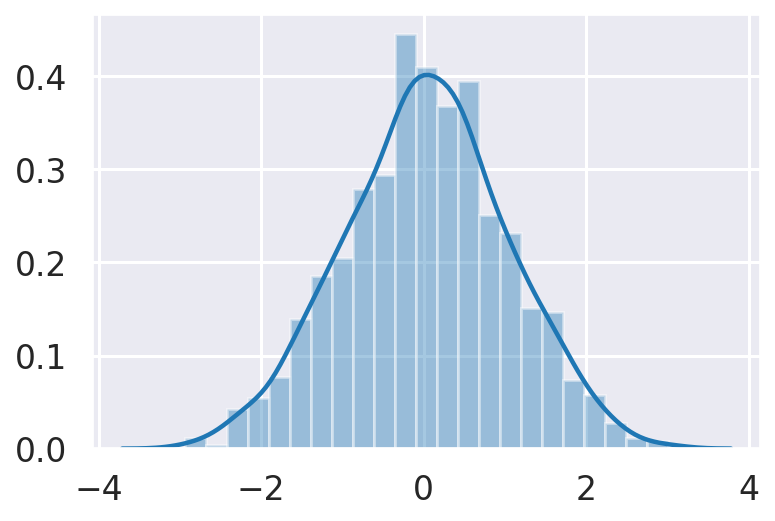

In [ ]:
# sampleメソッド
samples = normal.sample(1000)
sns.distplot(samples)

In [ ]:
# log_probメソッド
normal.log_prob(0.)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9189385>

In [ ]:
# 線形ガウス状態空間モデル
ndims = 2
step_std = 1.0
noise_std = 5.0

model = tfd.LinearGaussianStateSpaceModel(
  num_timesteps=100,
  transition_matrix=tf.linalg.LinearOperatorIdentity(ndims),
  transition_noise=tfd.MultivariateNormalDiag(
   scale_diag=step_std**2 * tf.ones([ndims])),
  observation_matrix=tf.linalg.LinearOperatorIdentity(ndims),
  observation_noise=tfd.MultivariateNormalDiag(
   scale_diag=noise_std**2 * tf.ones([ndims])),
  initial_state_prior=tfd.MultivariateNormalDiag(
   scale_diag=tf.ones([ndims])))

Instructions for updating:
Previously, `initial_step` would return the value passed to the constructor, even if that value was not `Tensor`-like. This behavior is now deprecated. In the future, it will always return a `Tensor`-like object.


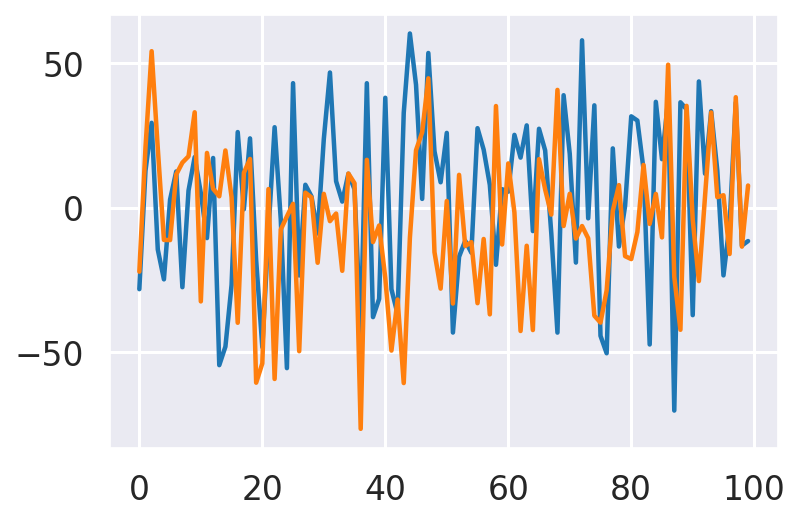

In [ ]:
# １００時点分の2次元の観測値が確率分布（モデル）からの1つのサンプルとなる。
y = model.sample()
for i in range(ndims):
    plt.plot(y[:, i])

## Bijector
tfp.bijectorは確率分布の変数変換に用いられます。DistributionをBijectorで変換することで、様々な確率分布を表現することができます。  
確率変数$X$を$Y=g(X)$により変換した際の、$Y$の確率密度関数$f_Y(y)$は下記のようになります。
<br>  
$$
X \sim f_X(x) \\
Y=g(X) \\
Y \sim f_Y(y) = f_X(g^{-1}(y)) \left | \frac{\delta g^{-1}(y)}{\delta y} \right | \\
\log f_Y(y) = \log f_X(g^{-1}(y)) + \log \left | \frac{\delta g^{-1}(y)}{\delta y} \right |
$$
<br>
例えば、確率変数Xが正規分布に従う時、exp(X)は対数正規分布に従います。exp(X)への変換をExp bijectorを用いて下記のように表現できます。

<class 'tensorflow_probability.python.distributions.transformed_distribution.TransformedDistribution'>


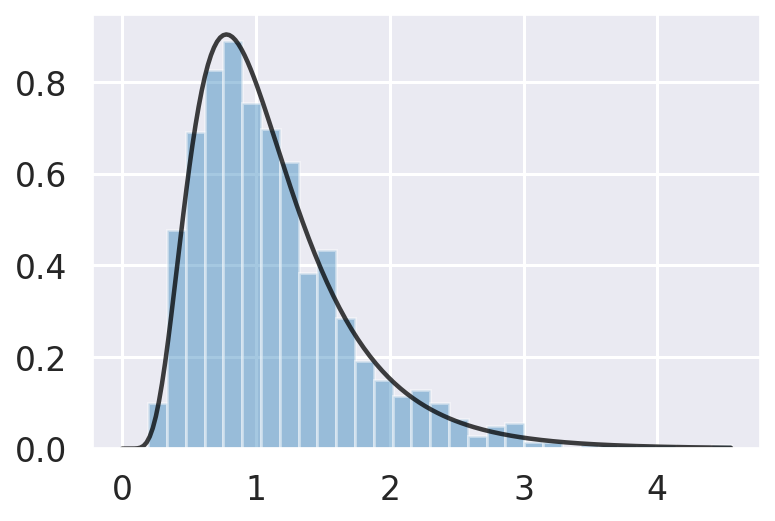

In [ ]:
exp_bijector = tfp.bijectors.Exp()
# 変数変換したDistribution
log_normal = exp_bijector(tfd.Normal(0., .5))
print(type(log_normal))

samples = log_normal.sample(1000)
xs = np.linspace(1e-10, np.max(samples), 200)
sns.distplot(samples, norm_hist=True, kde=False)
plt.plot(xs, log_normal.prob(xs), c='k', alpha=.75)

<class 'tensorflow_probability.python.distributions.transformed_distribution.TransformedDistribution'>


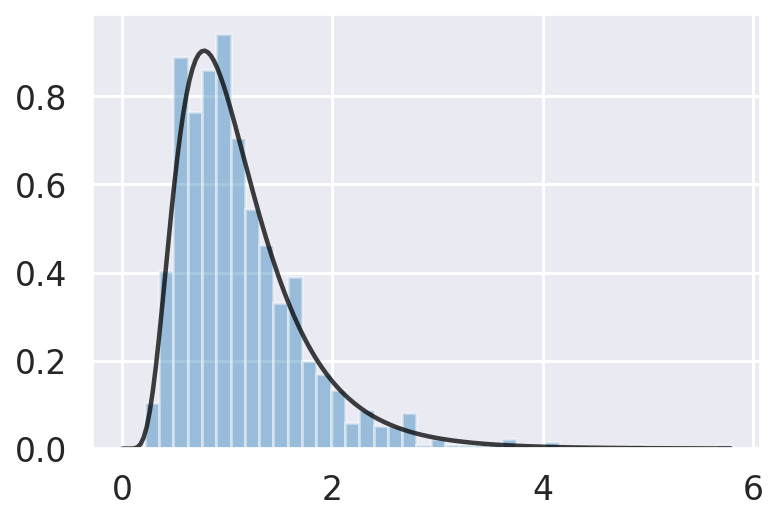

In [ ]:
## 参考：等価な書き方
# tfd.TransformedDistributionを用いてbijectorによる変換を表現することもできる。
# 複数のbijectorのリストを与えることも可能。
log_normal = tfd.TransformedDistribution(
    distribution=tfd.Normal(0., .5),
    bijector=tfp.bijectors.Exp()
)

print(type(log_normal))

samples = log_normal.sample(1000)
xs = np.linspace(1e-10, np.max(samples), 200)
sns.distplot(samples, norm_hist=True, kde=False)
plt.plot(xs, log_normal.prob(xs), c='k', alpha=.75)

## TFPにおけるshapeについて
TFPを用いてモデリングする際に混乱しやすい、shapeについて説明します。  
TFPには以下の3つのshapeの概念があります。

1. Batch shape 
2. Event shape
3. Sample shape

このうち、batch shape, event shapeはdistributionにひもづいています。  
また、sample shapeはsampleメソッドを実行した際に決まります。




In [ ]:
# パラメータのリストを渡すことで、異なる2つの正規分布をまとめて表現できる
# この場合、batch shapeになる
normal = tfd.Normal(loc=[-1., 1.], scale=[1., 1.5])
print(normal) # Batch: 2, Event: []

# sample shapeは一番左(外側)のaxisに追加される
print('shape of sampled Tensor:', normal.sample(10).shape) # Sample: 10, Batch: 2, Event: []

tfp.distributions.Normal("Normal", batch_shape=[2], event_shape=[], dtype=float32)
shape of sampled Tensor: (10, 2)


event shapeは１つのサンプルに含まれる次元の数を表します。例えば、二変量正規分布からのサンプルの場合、event shapeは2になります。  
batch shapeはパラメータが異なる複数の確率分布をまとめて取り扱う際に用いられます。例えば、Normal(1, 1), Normal(-1, 1)から独立に１つずつサンプルを取得する場合、batch shapeは２になります。

In [ ]:
# 二変量正規分布
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag = [1., 1.])
print("Batch shape:", mvn.batch_shape)
print("Event shape:", mvn.event_shape)

Batch shape: ()
Event shape: (2,)


In [ ]:
normals = tfd.Normal(loc=[-1., 1.], scale=1.) # scaleはbroadcastされ、[1., 1.]となる
print("Batch shape:", normals.batch_shape)
print("Event shape:", normals.event_shape)

Batch shape: (2,)
Event shape: ()


これらのdistributionから1つサンプルを取得すると、いずれもshape=2のTensorが返ってきます。  
batch shapeとevent shapeはdistributionにおいて意味上区別されているだけであり、sample()メソッドで得られるTensorには両者の区別はありません。

In [ ]:
mvn.sample().shape, normals.sample().shape

(TensorShape([2]), TensorShape([2]))

batch shape, event shapeの違いは（対数）確率の評価の際に顕在化します。  
batch shape=2の場合は、2つの異なるパラメータの確率分布をまとめて扱いますよ、という位置付けになります。そのため、２次元の入力についてそれぞれ対応する分布での確率を評価し、2つの値が返ってきます。  
一方、event_shape=2の場合は、1つのサンプルの次元が2であると考えるため、log_probでは1つの値が返ってきます。

In [ ]:
# Event shape=2の場合、Batch shape=2の場合
mvn.log_prob(mvn.sample()), normals.log_prob(normals.sample())

(<tf.Tensor: shape=(), dtype=float32, numpy=-1.8442044>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.3255908, -1.1056749], dtype=float32)>)



tfd.Independentを用いることで、batch shapeをevent shapeとして解釈し直すことができます。  
reinterpreted_batch_ndimsは右から何番目のbatch dimensionをevent dimensionに変換するかを指定します。  

In [ ]:
normals = tfd.Normal(loc=[-1., 1.], scale=1.) 
print("Batch shape:", normals.batch_shape)
print("Event shape:", normals.event_shape)
print()

normals_ind = tfd.Independent(normals, reinterpreted_batch_ndims=1)
print("Batch shape:", normals_ind.batch_shape)
print("Event shape:", normals_ind.event_shape)

Batch shape: (2,)
Event shape: ()

Batch shape: ()
Event shape: (2,)


In [ ]:
# 対数確率を評価してみる。tfd.Independentよりevent　shapeに変換された次元については、対数確率を評価する際にreduce_sumされる。
s = normals.sample()
tf.assert_equal(tf.reduce_sum(normals.log_prob(s)), normals_ind.log_prob(s))

実際にモデルを構築する際、ほとんどのケースでtfd.Independentを使うことになります。  
例えば線形回帰の対数尤度は以下のように表せます。N個の異なる平均パラメータで定められた正規分布について対数確率の和をとっていますが、tfd.IndependentによりNをbatch dimensionにすることで、この和を計算してくれることになります。


$$\ln p(\mathbf Y | \mathbf X, \mathbf w) = \sum_{n=1}^{N} \ln \mathcal N(y_n | \mathbf w^\top \mathbf x_n, \sigma_y^2)$$

同じようにevent shapeを操作するためのクラスとして、tfd.Sampleがあります。  
tfd.Independnetはパラメータが異なる確率分布からの独立なサンプルを取り扱ったのに対し、tfd.Sampleは、同じ確率分布からの独立なサンプル（独立同分布）を取り扱う際に用います。  
例えば同じコインを１０回投げるような場合を考えると、下記のように表現できます。

In [ ]:
bernoulli = tfd.Bernoulli(probs=0.5)
# 同一の確率分布から複数のサンプルをひとまとめにする
bernoulli_samples = tfd.Sample(bernoulli, sample_shape=10)
print(bernoulli_samples)

tfp.distributions.Sample("SampleBernoulli", batch_shape=[], event_shape=[10], dtype=int32)


In [ ]:
s = bernoulli_samples.sample()
print('shape of single sample:', s.shape)

# 複数サンプルについて、対数確率の和が算出される
bernoulli_samples.log_prob(s)

shape of single sample: (10,)


<tf.Tensor: shape=(), dtype=float32, numpy=-6.931472>

## JointDistribution

ベイズ推論ではパラメータの事後分布$p(\theta | y)$を求めることに興味があります。事後分布は下式のように表現できます。  
  
$$p(\theta | y) = \frac{p(y, \theta)}{p(y)} = \frac{p(y | \theta) p(\theta)}{\int p(y | \theta) p(\theta) \rm d \theta}$$  

モデルが複雑になってくると、周辺確率$p(y)$を求めるのは困難となり、上式から直接事後分布を求めるのは難しいです。  
そこで、MCMCや変分推論のよる事後分布の近似推論が必要になります。これらの推論の際は、**同時分布$p(y, \theta)$の計算が必要**になります。

TFPで同時分布を表現する基底クラスは、tfp.distributions.JointDistributionになります。JointDistributionにはサブクラスがいくつかあり、それぞれモデルの書き方が少し異なります。  
今回はJointDistributionCoroutineを利用します。PyMC3に近い書き方ができます。

### 例）正規分布のパラメータ推定
正規分布に従うデータが１００個あるとき、正規分布の平均と標準偏差を推論する問題を考えます。

Text(0.5, 1.0, 'Histogram of observed data')

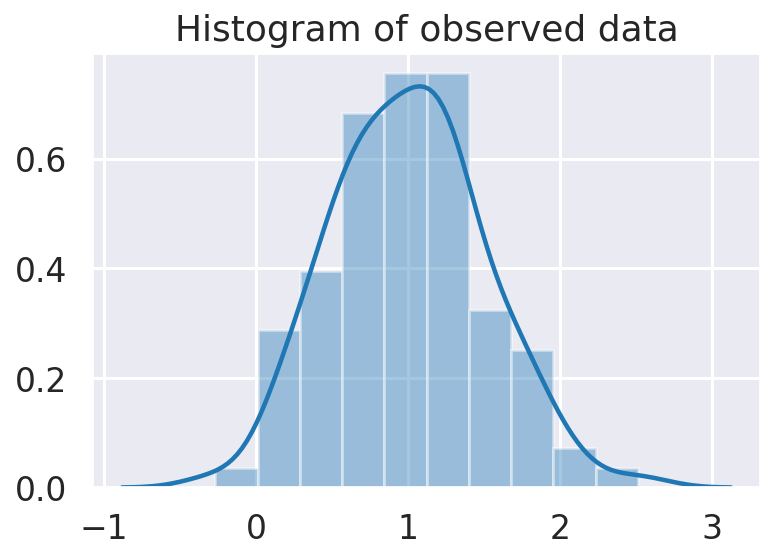

In [ ]:
mu_true, sigma_true = 1.0, 0.5
n_sample = 100

normal = tfd.Normal(loc=mu_true, scale=sigma_true)
data = normal.sample(n_sample)

sns.distplot(data)
plt.title('Histogram of observed data')

まずパラメータの事前分布を設定し、モデル式を書いてみます。平均$\mu$の事前分布は正規分布とします。また、標準偏差$\sigma$の事前分布は正の値をとる確率分布にする必要があり、ここでは半コーシー分布としています。

$$\begin{eqnarray}
\mu &\sim& {\rm Normal}(0, 10) \\
\sigma &\sim& {\rm Halfcauchy}(5) \\
y_i &\sim& {\rm Normal} (\mu, \sigma), \quad i=1, \dots , n
\end{eqnarray}$$
<br>
tfd.JointdistributionCoroutineを用いてこのモデルを定義すると以下のようになります。jointが同時分布です。

In [ ]:
# 事前分布はRootでラップする
Root = tfd.JointDistributionCoroutine.Root
def model():
    mu = yield Root(tfd.Normal(loc=0, scale=10)) # 平均muの事前分布
    sigma = yield Root(tfd.HalfCauchy(loc=0, scale=5)) #　標準偏差sigmaの事前分布
    
    # 全データ点について、対数確率の和を取りたいので、tfd.Sampleでevent shapeをn_sampleにする。
    # 他のパラメータ（この場合mu, sigma）に条件づけられた確率分布はRootでラップしなくて良い
    y = yield tfd.Sample(tfd.Normal(loc=mu, scale=sigma), n_sample)
    
joint = tfd.JointDistributionCoroutine(model)
print(type(joint))

<class 'tensorflow_probability.python.distributions.joint_distribution_coroutine.JointDistributionCoroutine'>


jointは確率分布なので、sampleメソッドやlog_probメソッドが使えます。sampleメソッドを実行すると、まずmu, sigmaを事前分布からサンプルし、それらの値を用いてyをサンプリングしていることになります。

In [ ]:
mu_sample, sigma_sample, y_sample = joint.sample(5) # mu, y
print(joint.log_prob(mu_sample, sigma_sample, y_sample)) # 対数同時確率

tf.Tensor([ -32.39647  -74.3895  -384.35724 -296.30154 -121.22296], shape=(5,), dtype=float32)


設定した事前分布の元でサンプリングされたyをいくつか可視化してみます。

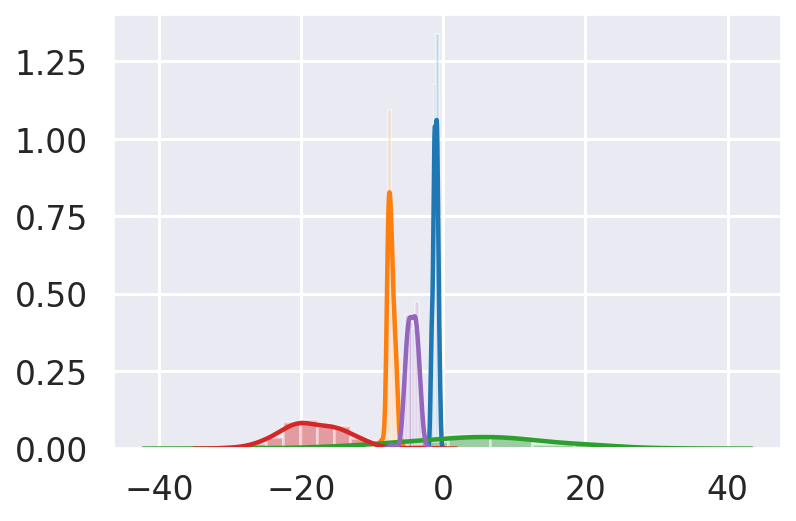

In [ ]:
# 事前分布を用いたシミュレーション
for i in y_sample:
    sns.distplot(i)

## MCMCによる近似推論
モデルの定義ができたら、いよいよ目的であるパラメータの事後分布に関する推論を行います。  
今回はtfp.mcmcモジュールに実装されているマルコフ連鎖モンテカルロ法(MCMC)を用います。TFPには事後分布の近似推論の手法として、MCMC
の他に、変分推論(variational inference)もtfp.viモジュールに実装されています。変分推論はMCMCに比べ推論の精度が低下するケースもありますが、より高速に実行可能です。  

引き続き、正規分布のパラメータ推定を例としています。  
観測データが与えられたもとでの事後分布を求めたいので、まず先ほど設計した同時分布を観測データで条件づけます。

In [ ]:
# yが与えられた元での、mu,sigmaの(正規化されていない)事後確率を返す関数。
def unnormalized_log_posterior(mu, sigma):
    return joint.log_prob(mu, sigma, data) # 観測データを与える

MCMCのアルゴリズムにもいろいろありますが、今回はハミルトニアン・モンテカルロ法(HMC)を用います。
下記コードはやや長いですが、MCMCを実行する際に必要な以下の設定を行っています。

* サンプリング数(num_results)： 事後分布からのサンプルをいくつ取得するか
* バーンイン期間(num_burnin_steps)：MCMCがまだ収束していないと判断し、捨てるサンプルの数
* パラメータの初期値(current_state)：適当な値を設定
* 遷移核(kernel): MCMCのアルゴリズム


In [ ]:
num_results = 4000
num_burnin_steps = 1000

# パラメータの初期値
current_state = [tf.ones([], name='init_mu'),
                 tf.ones([], name='init_sigma')]

# ハミルトニアン・モンテカルロ法を用いる。step sizeというハイパーパラメータの調整が必要になるが、
# SimpleStepSizeAdaptationでラップすることで、自動的に調整してくれる。
kernel = tfp.mcmc.SimpleStepSizeAdaptation(
          ｔfp.mcmc.HamiltonianMonteCarlo(
              target_log_prob_fn=unnormalized_log_posterior,
              step_size=0.1,
          num_leapfrog_steps=5),
      num_adaptation_steps=int(num_burnin_steps * 0.8))


# tf.functionでデコレートすることで、計算グラフがコンパイルされ、高速に実行される
@tf.function(autograph=False, experimental_compile=True)
def do_sampling(num_results, num_burnin_steps, current_state, kernel):
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=current_state,
      kernel=kernel)


states, kernel_results = do_sampling(num_results, num_burnin_steps, current_state, kernel)

accept_rate = kernel_results.inner_results.is_accepted.numpy().mean(axis=0)
print('Acceptance rate: {:.1%}'.format(accept_rate))

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 56.2%


MCMCがうまくいっているかを確認するために、トレースプロットを出力します。  
ここでは、arvizというライブラリを利用します。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb0f214c88>,
      dtype=object)

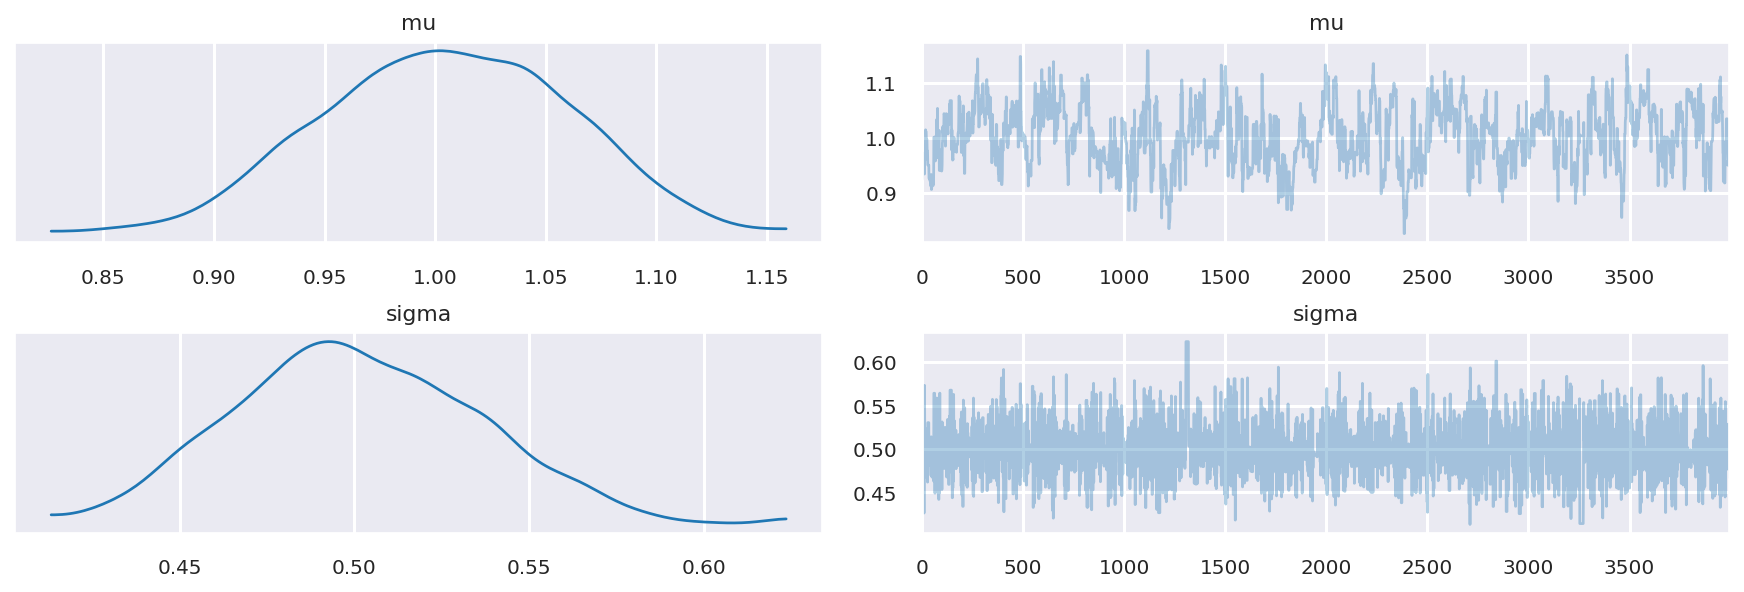

In [ ]:
var_name = ['mu', 'sigma']
trace = format_trace(states, var_name)
az.plot_trace(trace)

左側が事後分布の密度関数（正確には、MCMCサンプルについてカーネル密度推定したもの）、右側がトレースプロットです。トレースプロットを確認すると、一定の値を中心にランダムに変動しているように見えるため、正しく定常分布に収束していると言えそうです。  

次に、事後分布に関する統計量を算出します。下表のmeanが事後分布の平均値(expected a posteriori, EAP)を表しており、正しく推定できていそうです。

In [ ]:
az.summary(trace)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,1.004,0.055,0.901,1.099,0.005,0.004,122.0,122.0,124.0,239.0,NaN
sigma,0.500,0.035,0.442,0.568,0.001,0.001,1740.0,1683.0,1766.0,896.0,NaN


収束の良さをより正確に評価するためには、複数chainのMCMCを実施する必要があります。TFPでは、パラメータの初期値のshapeにより、chain数を指定することができます。

In [ ]:
# パラメータの初期値
n_chains = 3
current_state = [tf.random.uniform([n_chains], -2, 2, name='init_mu'),
                 tf.random.uniform([n_chains], 1, 4, name='init_sigma')]

states, kernel_results = do_sampling(num_results, num_burnin_steps, current_state, kernel)

accept_rate = kernel_results.inner_results.is_accepted.numpy().mean(axis=0)
print('Acceptance rate: {:.1%}, {:.1%}, {:.1%}'.format(*accept_rate))

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 65.5%, 64.6%, 63.8%


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,1.008,0.051,0.912,1.101,0.001,0.001,2622.0,2621.0,2624.0,4437.0,1.0
sigma,0.502,0.037,0.435,0.572,0.001,0.000,3568.0,3430.0,3765.0,2610.0,1.0


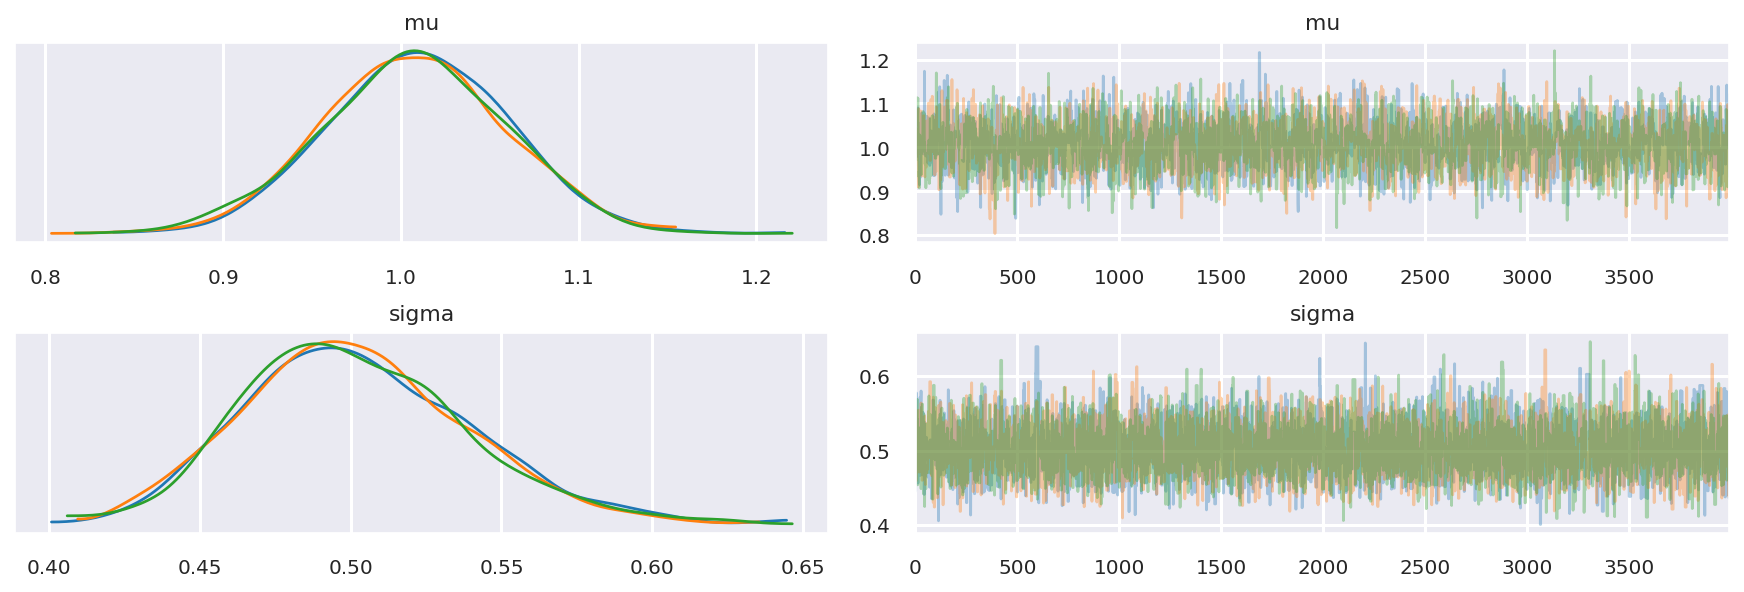

In [ ]:
var_name = ['mu', 'sigma']
trace = format_trace(states, var_name, chain_dim=1)
az.plot_trace(trace)
az.summary(trace)

3つのchainの結果はほぼ一致しており、MCMCの収束は問題ないと言えます。
複数chainのMCMCを実行した場合、Rhatという値を計算することができ、この値が1.1未満というのが収束の目安とされています。

# 簡単なモデリングの例
ここからは、もう少し実用的なモデルの例を説明します。

## 変化点検知
年間に起きる大災害の数のデータセットを扱います。
プロットを見ると1900年ごろを境にして件数が減少したように見えます。



Text(0.5, 0, 'Year')

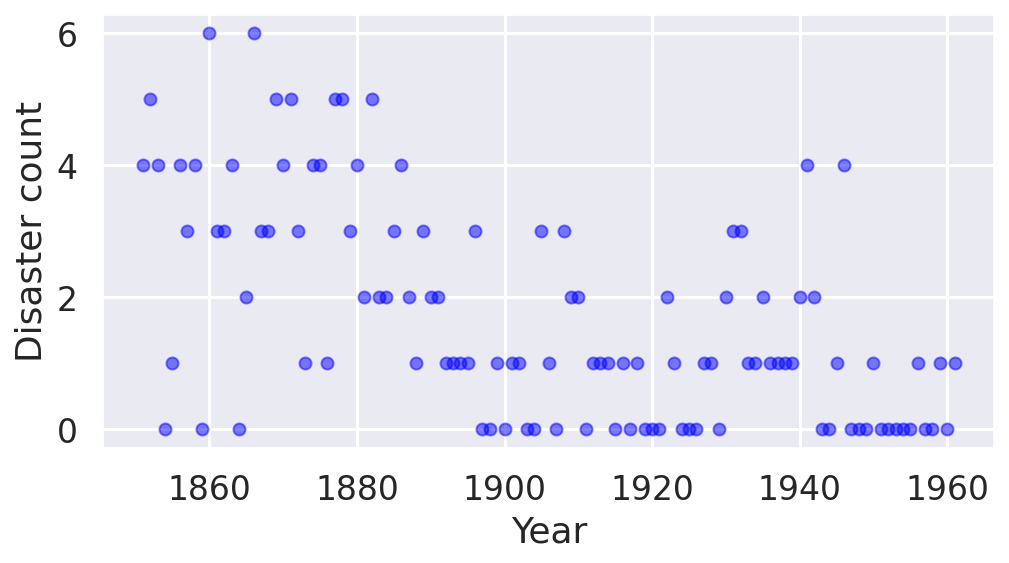

In [ ]:
disaster_data = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)

plt.figure(figsize=(8, 4))
plt.plot(years, disaster_data, "o", color='b', markersize=6, alpha=0.5)
plt.ylabel("Disaster count")
plt.xlabel("Year")

めったにない事象の単位時間あたりの発生回数が従う確率分布として、ポアソン分布が知られています。ポアソン分布のパラメータは平均パラメータ$\lambda$のみです。
ここでは、災害の発生件数はポアソン分布に従い、そのパラメータ$\lambda$が期間中のどこかで１回だけ変化したと仮定して、モデリングすることにします。

変化点をs、変化前・変化後のポアソン分布のパラメータをそれぞれe, lとします。変化点に関する事前情報がないと想定し、sの事前分布は（離散）一様分布とします。e, lの事前分布は正の値をとる確率分布にする必要があり、ここでは指数分布とします。

$$
\begin{align*}
(D_t|s,e,l)&\sim \text{Poisson}(r_t), \\
  & \,\quad\text{with}\; r_t = \begin{cases}e & \text{if}\; t < s\\l &\text{if}\; t \ge s\end{cases} \\
s&\sim\text{Discrete Uniform}(t_l,\,t_h) \\
e&\sim\text{Exponential}(r_e)\\
l&\sim\text{Exponential}(r_l)
\end{align*}
$$

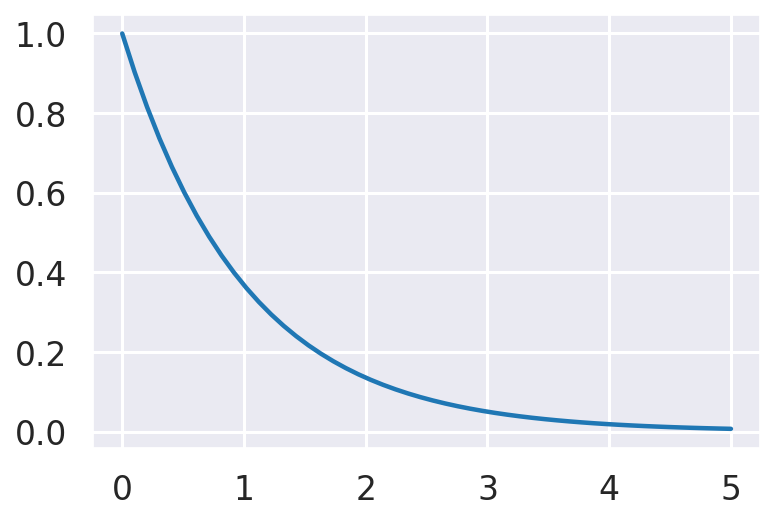

In [ ]:
# 参考：指数分布
exp = tfd.Exponential(rate=1)
xx = np.linspace(0, 5)
plt.plot(xx, exp.prob(xx))

In [ ]:
Root = tfd.JointDistributionCoroutine.Root
def model():
    e = yield Root(tfd.Exponential(rate=1.))
    l = yield Root(tfd.Exponential(rate=1.))
    s = yield Root(tfd.Uniform(0., high=len(years)))
    d_t = yield tfd.Independent(
        tfd.Poisson(rate=tf.where(np.arange(len(years)) < s, e, l)),
        reinterpreted_batch_ndims=1)

# 複数チェーンのMCMCを実行しようとすると、s, e, lが２次元になるため、tf.where内のshapeが合わずエラーになる。
# tf.newaxisなどを用いて、バッチ処理に対応できるようにする必要がある。（参考：）
# まだexperimentalのようだが、AutoBatchedを使えば自動的にモデルをベクトル化してくれる。
joint = tfd.JointDistributionCoroutineAutoBatched(model)

def unnormalized_log_posterior(e, l, s):
    return joint.log_prob(e, l, s, disaster_data)

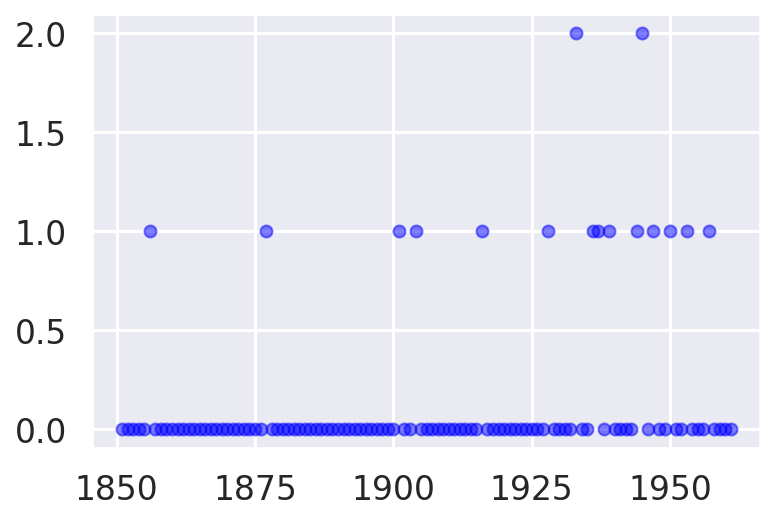

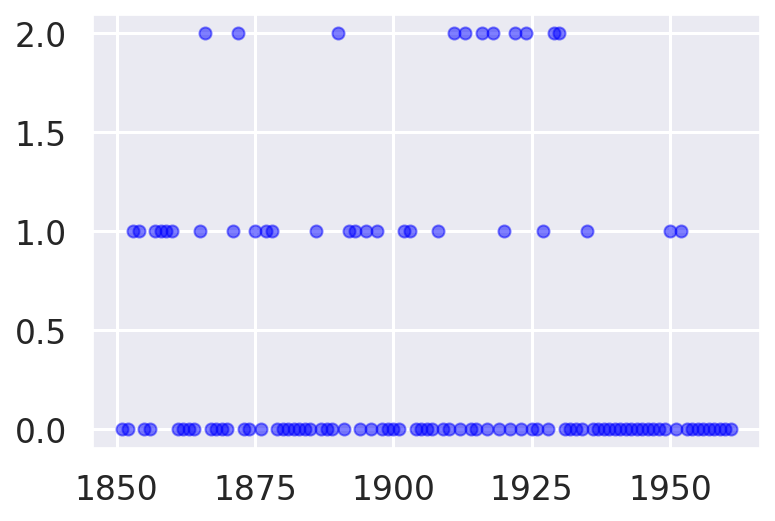

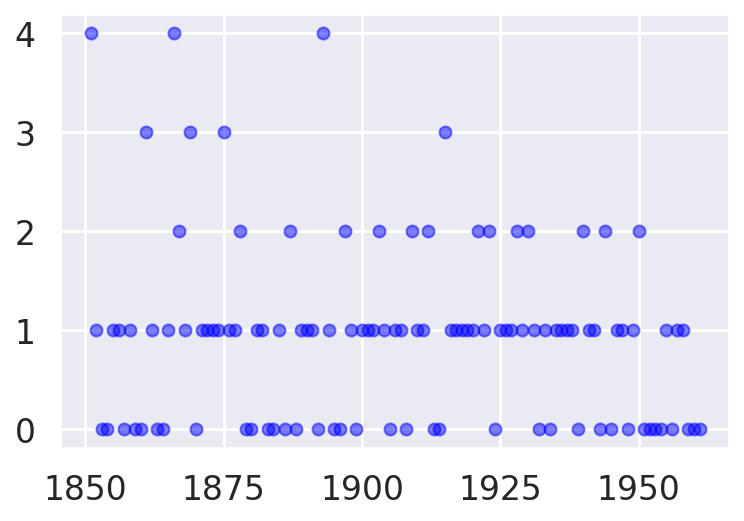

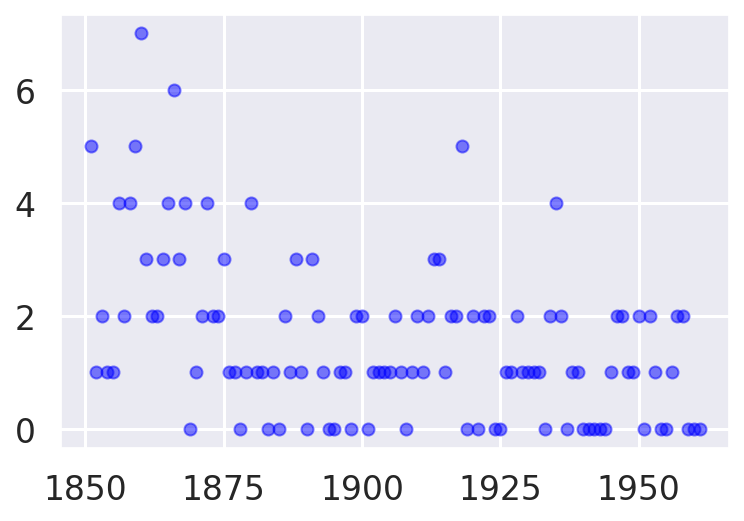

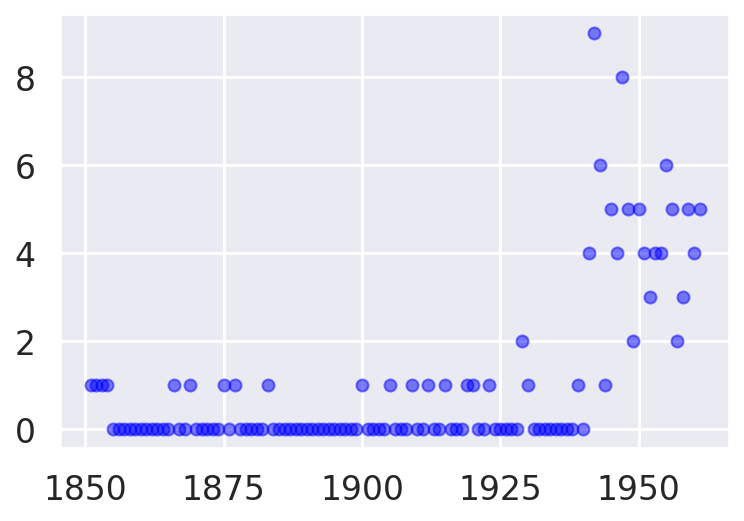

In [ ]:
# 事前分布を用いたシミュレーション
d_t_samples = joint.sample(5)[-1]

for d_t in d_t_samples:
    plt.figure()
    plt.plot(years, d_t, "o", color='b', markersize=6, alpha=0.5)

MCMCによる事後分布の推論を行います。ここで、各パラメータが取りうる値に制約があるため、注意が必要です。

bijectorを用いて、制約のない空間でサンプリングされたパラメータの値が制約を満たすように変換する必要があります。
e, lは正の値をとる必要があるので、ここではsoftplusを用います。指数関数による変換でも構いません。  
また、変化点sは0からlen(years)の範囲の値をとる必要があるため、シグモイド関数による変換を利用します。

In [ ]:
%%time
num_results = 10000
num_burnin_steps = 3000

@tf.function(autograph=False, experimental_compile=True)
def do_sampling():
   kernel = tfp.mcmc.TransformedTransitionKernel(
       inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=unnormalized_log_posterior,
          step_size=0.1,
          num_leapfrog_steps=5),
       # パラメータの制約を満たすように、bijectorで変換する
       bijector=[     
          tfb.Softplus(),
          tfb.Softplus(),
          tfb.Sigmoid(low=0., high=tf.cast(len(years), dtype=tf.float32))
      ])
   kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8 * num_burnin_steps))

   states = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          tf.random.uniform([3], 1, 3, name='init_early_disaster_rate'),
          tf.random.uniform([3], 1, 3, name='init_late_disaster_rate'),
          tf.random.uniform([3], 0, 3, name='init_switchpoint')
      ],
      kernel=kernel)
   return states


states, kernel_results = do_sampling()

accept_rate = kernel_results.inner_results.inner_results.is_accepted.numpy().mean(axis=0)
print('Acceptance rate: {:.1%}, {:.1%}, {:.1%}'.format(*accept_rate))

Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.


/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 77.3%, 77.0%, 77.8%


事後分布とトレースプロットを表示します。概ね問題なく収束していると言えそうです。

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
e,3.094,0.299,2.567,3.679,0.032,0.023,86.0,86.0,90.0,160.0,1.04
l,0.943,0.117,0.723,1.163,0.008,0.006,214.0,209.0,221.0,375.0,1.01
s,39.418,2.393,35.001,43.597,0.132,0.094,328.0,327.0,349.0,518.0,1.01


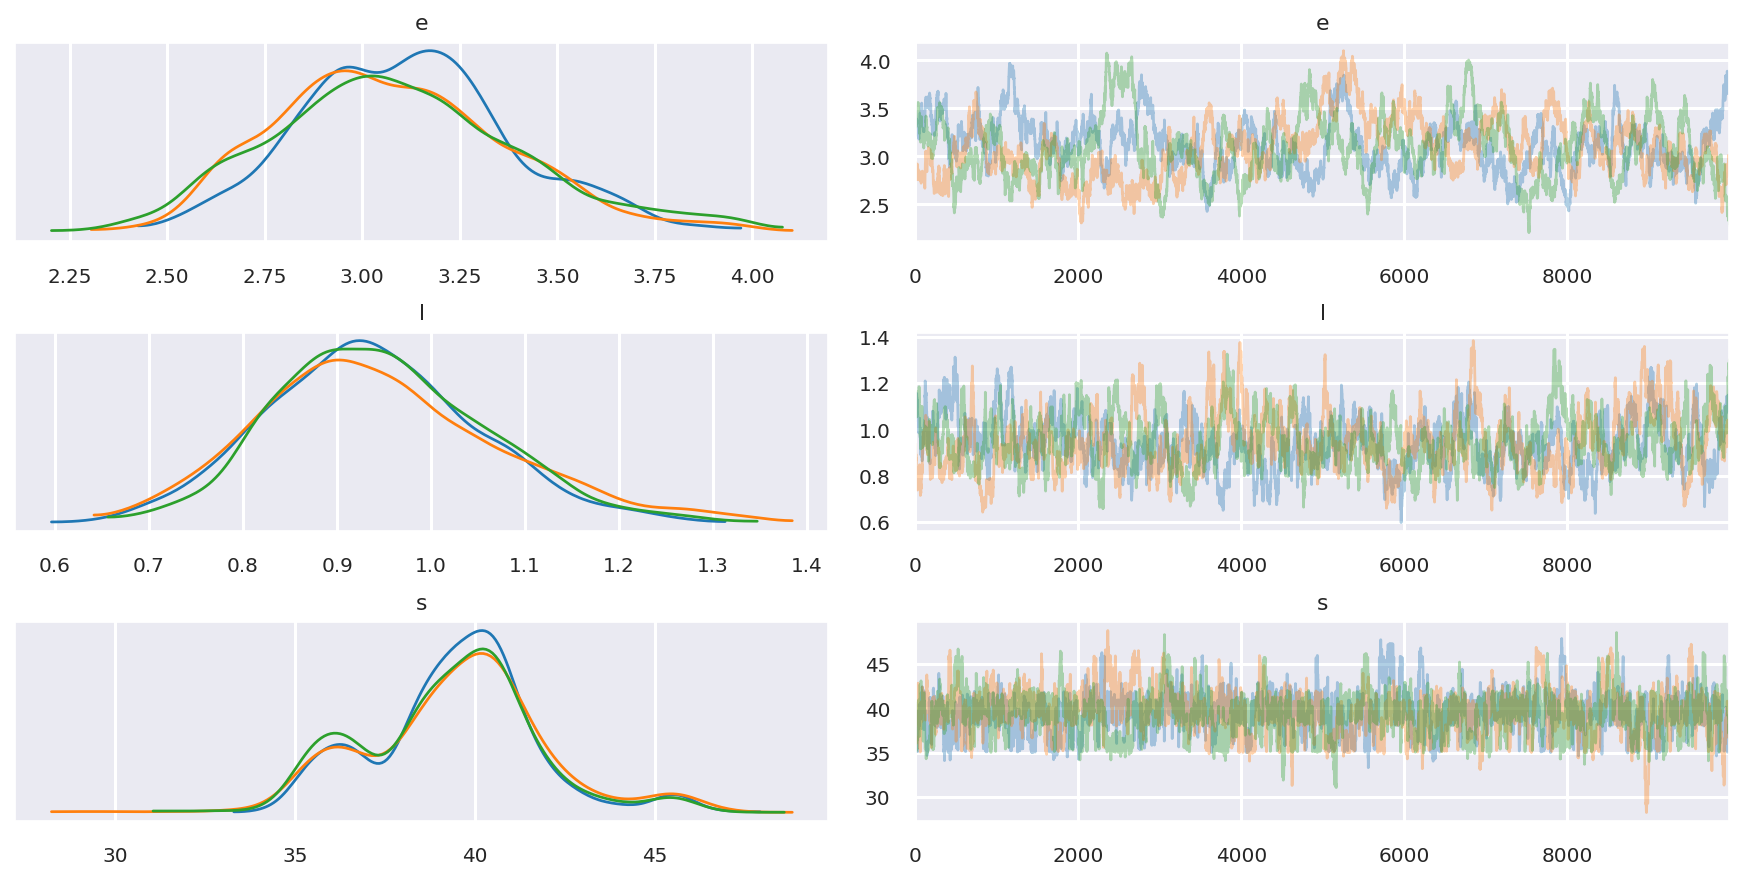

In [ ]:
var_name = ['e', 'l', 's']
trace = format_trace(states, var_name, chain_dim=1)
az.plot_trace(trace)

az.summary(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb0b877fd0>,
      dtype=object)

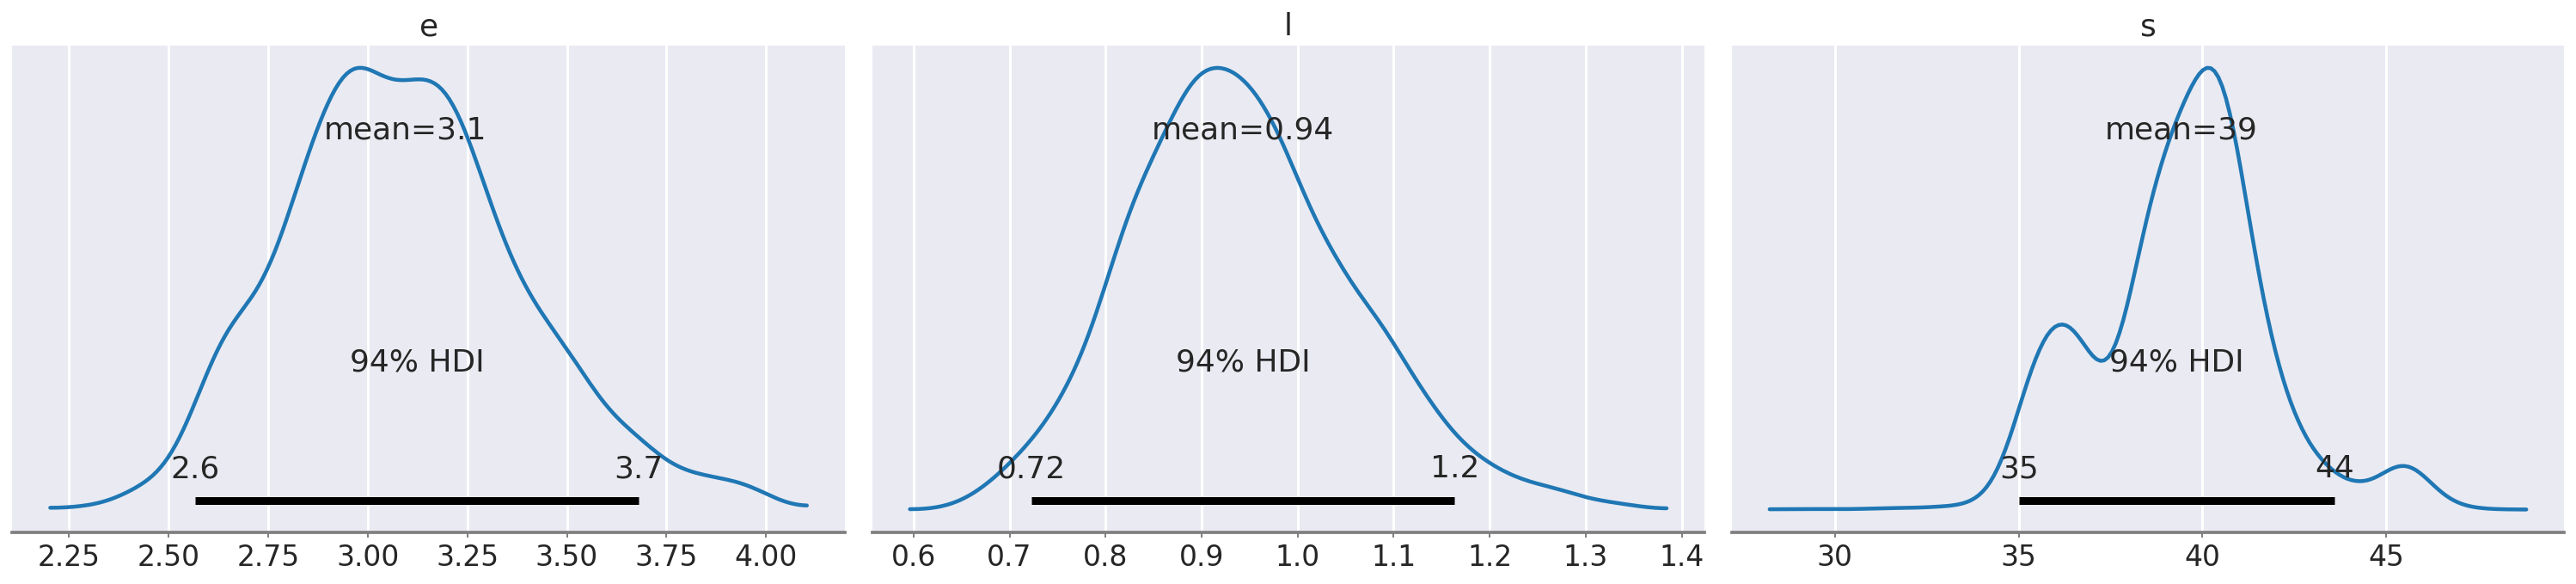

In [ ]:
# 参考：事後分布の可視化（plot_traceとsummaryで出力される情報をまとめて可視化）
az.plot_posterior(trace)

In [ ]:
e_eap, l_eap, s_eap = [tf.reduce_mean(s) for s in states]
r_t_eap = tf.where(np.arange(len(years)) < s_eap, e_eap, l_eap)

推論結果を確認するため、パラメータe, l, sの事後分布の平均値、及び事後分布からのいくつかのサンプルについて、ポアソン分布の平均(r_t)を可視化してみます。

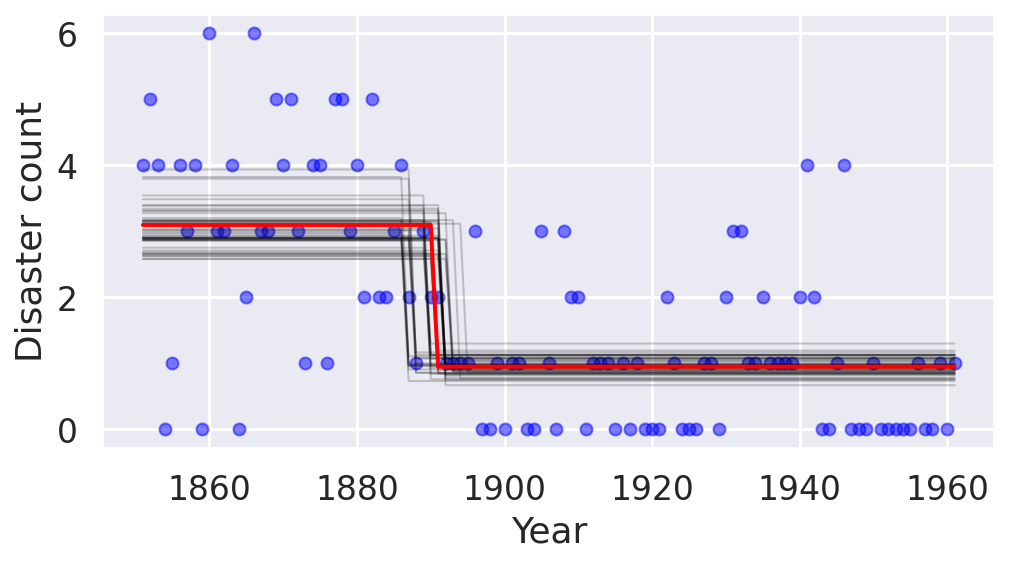

In [ ]:
rates = tf.where(np.arange(len(years)) < tf.reshape(states[2], [-1, 1]), tf.reshape(states[0], [-1, 1]), tf.reshape(states[1], [-1, 1]))

plt.figure(figsize=(8, 4))
plt.plot(years, disaster_data, "o", color='b', markersize=6, alpha=0.5)
plt.ylabel("Disaster count")
plt.xlabel("Year")

# 事後分布からのサンプルを50個取得し、ポアソン分布の平均値を描いてみる
rates = tf.random.shuffle(rates)
for i in range(50):
    plt.plot(years, rates[i], lw=1, alpha=0.2, color='k')
# EAP推定量
plt.plot(years, r_t_eap, lw=2, color='r')

変化点(s)、変化前の平均値(e)、変化後の平均値(l)、いずれも妥当な推論結果と言えそうです。

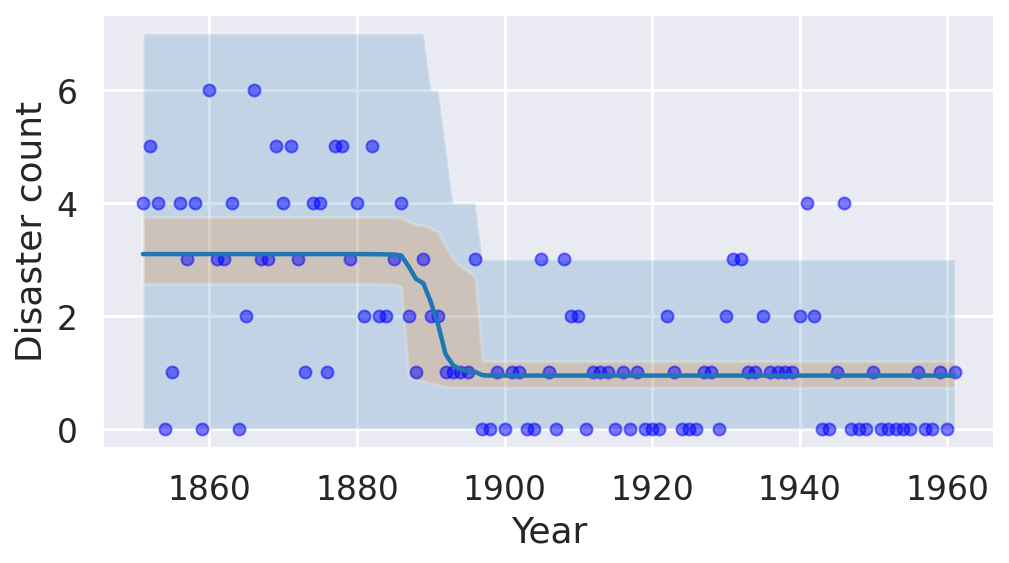

In [ ]:
# 参考：r_t, D_tの95%区間を描画
samples = tfd.Poisson(rate=rates).sample()
obs_low, obs_high = np.percentile(samples, [2.5, 97.5], axis=0)
rates_low, rates_high = np.percentile(rates, [2.5, 97.5], axis=0)
means = np.mean(rates, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(years, disaster_data, "o", color='b', markersize=6, alpha=0.5)
plt.ylabel("Disaster count")
plt.xlabel("Year")
plt.plot(years, means)
plt.fill_between(years, obs_low, obs_high, alpha=0.2)
plt.fill_between(years, rates_low, rates_high, alpha=0.2)

## 混合正規分布
次に、混合正規分布のパラメータ推定を題材とします。  
２つの学校におけるテストの成績のデータがあり、それぞれの学校での各生徒の成績は正規分布に従うと仮定します。ただし、2つの学校では生徒の学力やそのばらつきに違いがあるため、異なるパラメータの正規分布に従うと考えます。また、何らかの手違いにより２校のテスト結果が混ざってしまい、各生徒の在籍校や生徒数は分からないとします。 

成績のヒストグラムは下図のようになります。ここから、各校における平均、標準偏差、さらに両校の生徒数の比率を推論してみましょう。

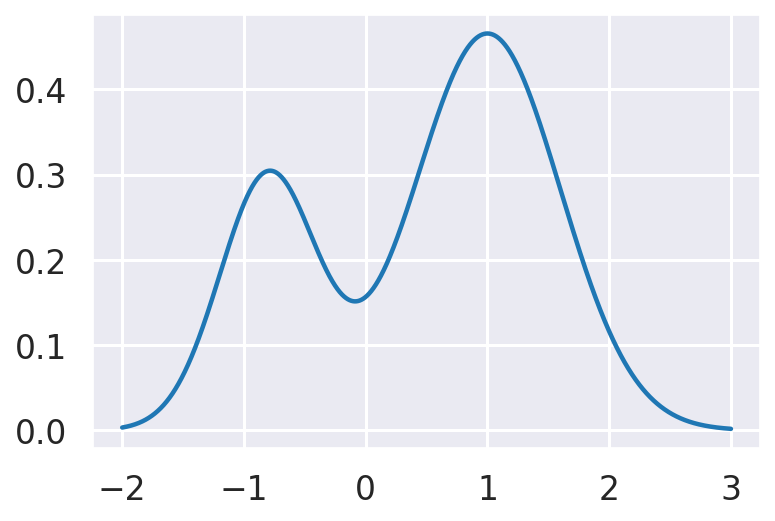

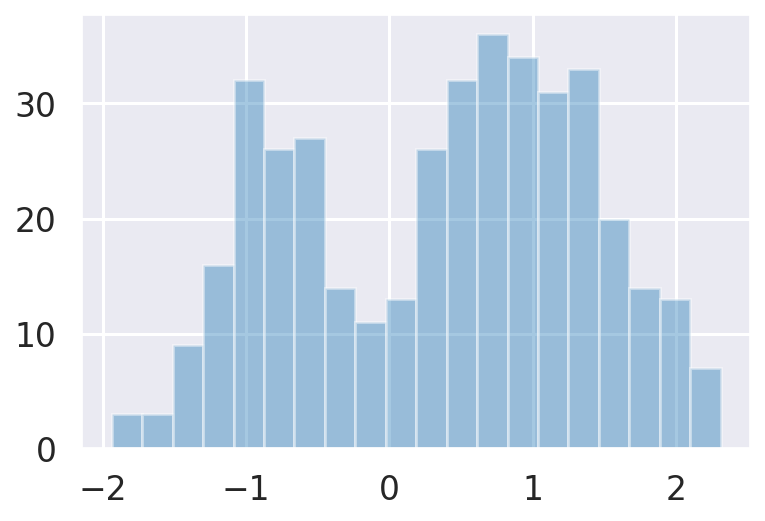

In [ ]:
gm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.3, 0.7]),
    components_distribution=tfd.Normal(
      loc=[-0.8, 1],       
      scale=[0.4, 0.6]))

x = np.linspace(-2., 3., int(1e4), dtype=np.float32)
plt.plot(x, gm.prob(x))

n = 400
data = gm.sample(n, seed=0)

ｐlt.figure()
sns.distplot(data, bins=20, kde=False)

In [ ]:
n_comp = 2
Root = tfd.JointDistributionCoroutine.Root
def model():
    pi = yield Root(tfd.Dirichlet(concentration=10 * tf.ones(n_comp))) # (E: n_comp)

    mu = yield Root(tfd.Independent( # Independentを入れてevent shapeにしておかないと複数チェーンのMCMCを実施した際にエラーになる。
      tfd.Normal(loc=tf.zeros(n_comp), scale=10 * tf.ones(n_comp)), 
      reinterpreted_batch_ndims=1)) # (E: n_comp)

    sigma = yield Root(tfd.Independent(
      tfd.HalfCauchy(loc=tf.zeros(n_comp), scale=5 * tf.ones(n_comp)), 
      reinterpreted_batch_ndims=1)) # (E: n_comp)

    y = yield tfd.Sample(
      tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=pi), 
        components_distribution=tfd.Normal(loc=mu, scale=sigma)
        ), 
      sample_shape=n) # (E: n)

joint = tfd.JointDistributionCoroutine(model)   

def target_log_prob_fn(pi, mu, sigma):
    return tf.reduce_sum(joint.log_prob(pi, mu, sigma, data))

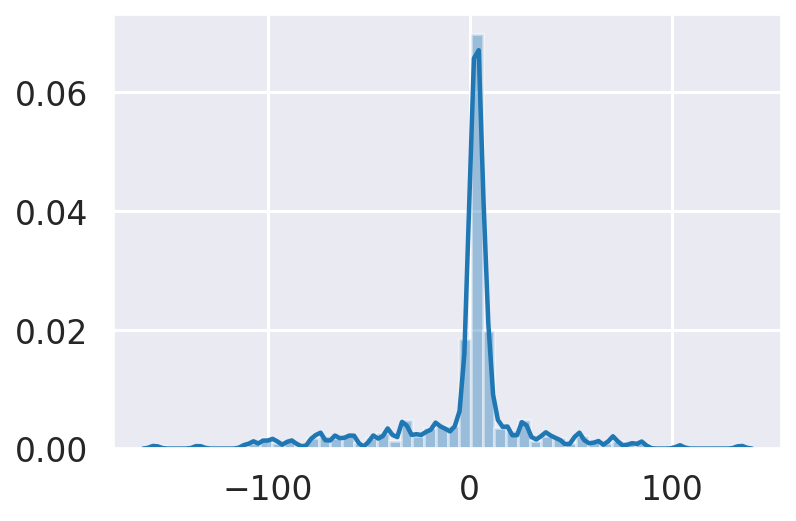

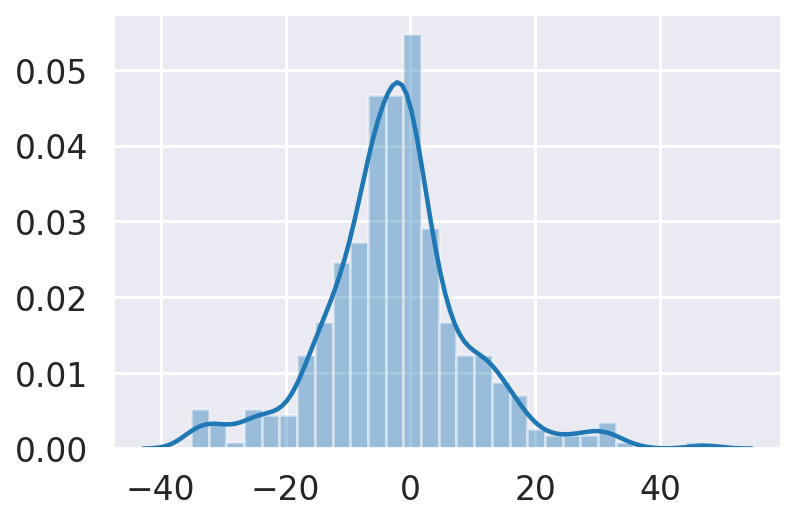

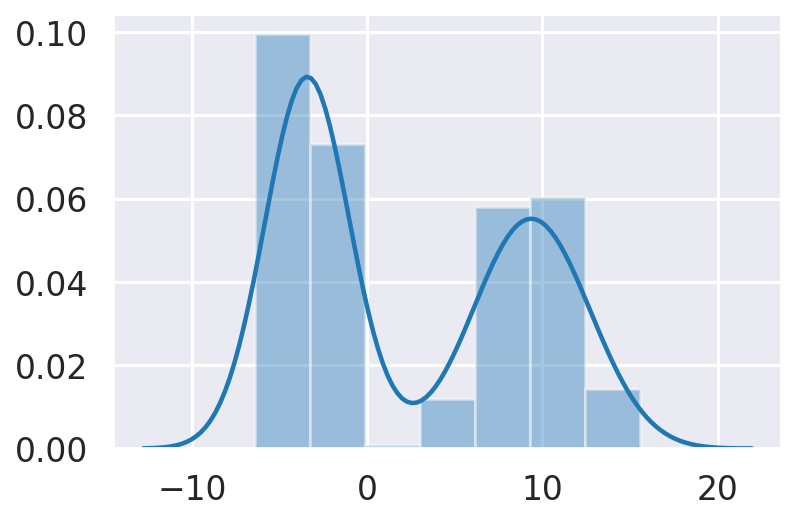

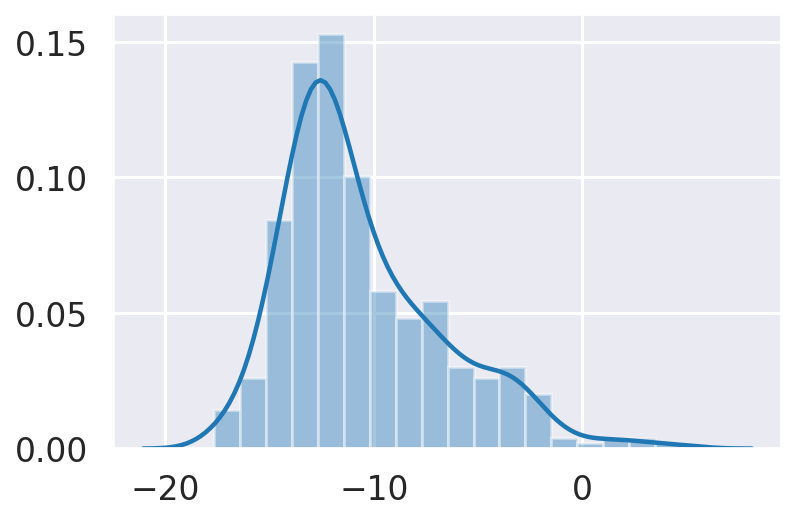

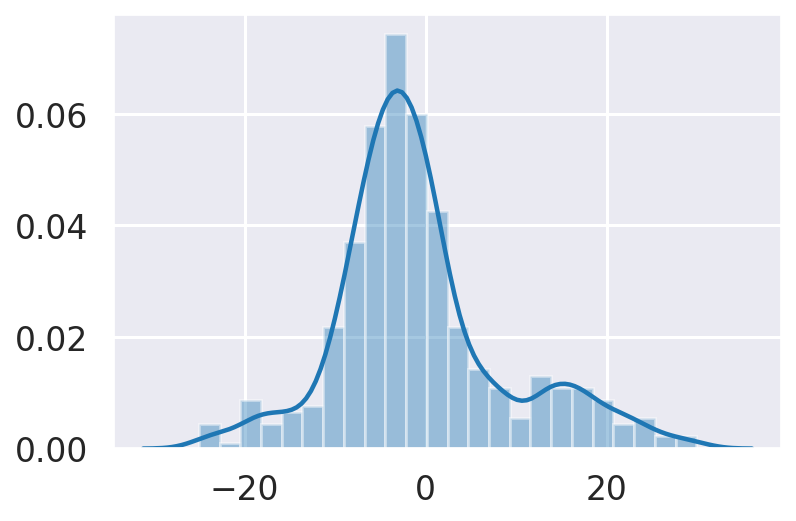

In [ ]:
# 事前分布を用いたシミュレーション
y_sample = joint.sample(5)[-1]

for y_s in y_sample:
    plt.figure()
    sns.distplot(y_s)

In [ ]:
dtype = np.float32
n_chains = 3

initial_state = [
    tf.random.uniform((n_chains, n_comp), 0, 1, name='init_pi'),
    tf.random.uniform((n_chains, n_comp), -2, 2, name='init_mu'),
    tf.random.uniform((n_chains, n_comp), 0, 2, name='init_sigma'),
]

unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.Identity(),
    tfb.Softplus()
  ]

In [ ]:
%%time
@tf.function(autograph=False)
def sample():
  return tfp.mcmc.sample_chain(
    num_results=4000,
    num_burnin_steps=1000,
    current_state=initial_state,
    kernel=tfp.mcmc.SimpleStepSizeAdaptation(
        tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=target_log_prob_fn,
                 step_size=0.01,
                 num_leapfrog_steps=5),
            bijector=unconstraining_bijectors),
         num_adaptation_steps=400),
    trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

states, is_accepted = sample()

CPU times: user 26.3 s, sys: 727 ms, total: 27 s
Wall time: 15.7 s


In [ ]:
print('acceptance rate: {:.1%}'.format(is_accepted.numpy().mean()))

acceptance rate: 74.9%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb0aca1cc0>,
      dtype=object)

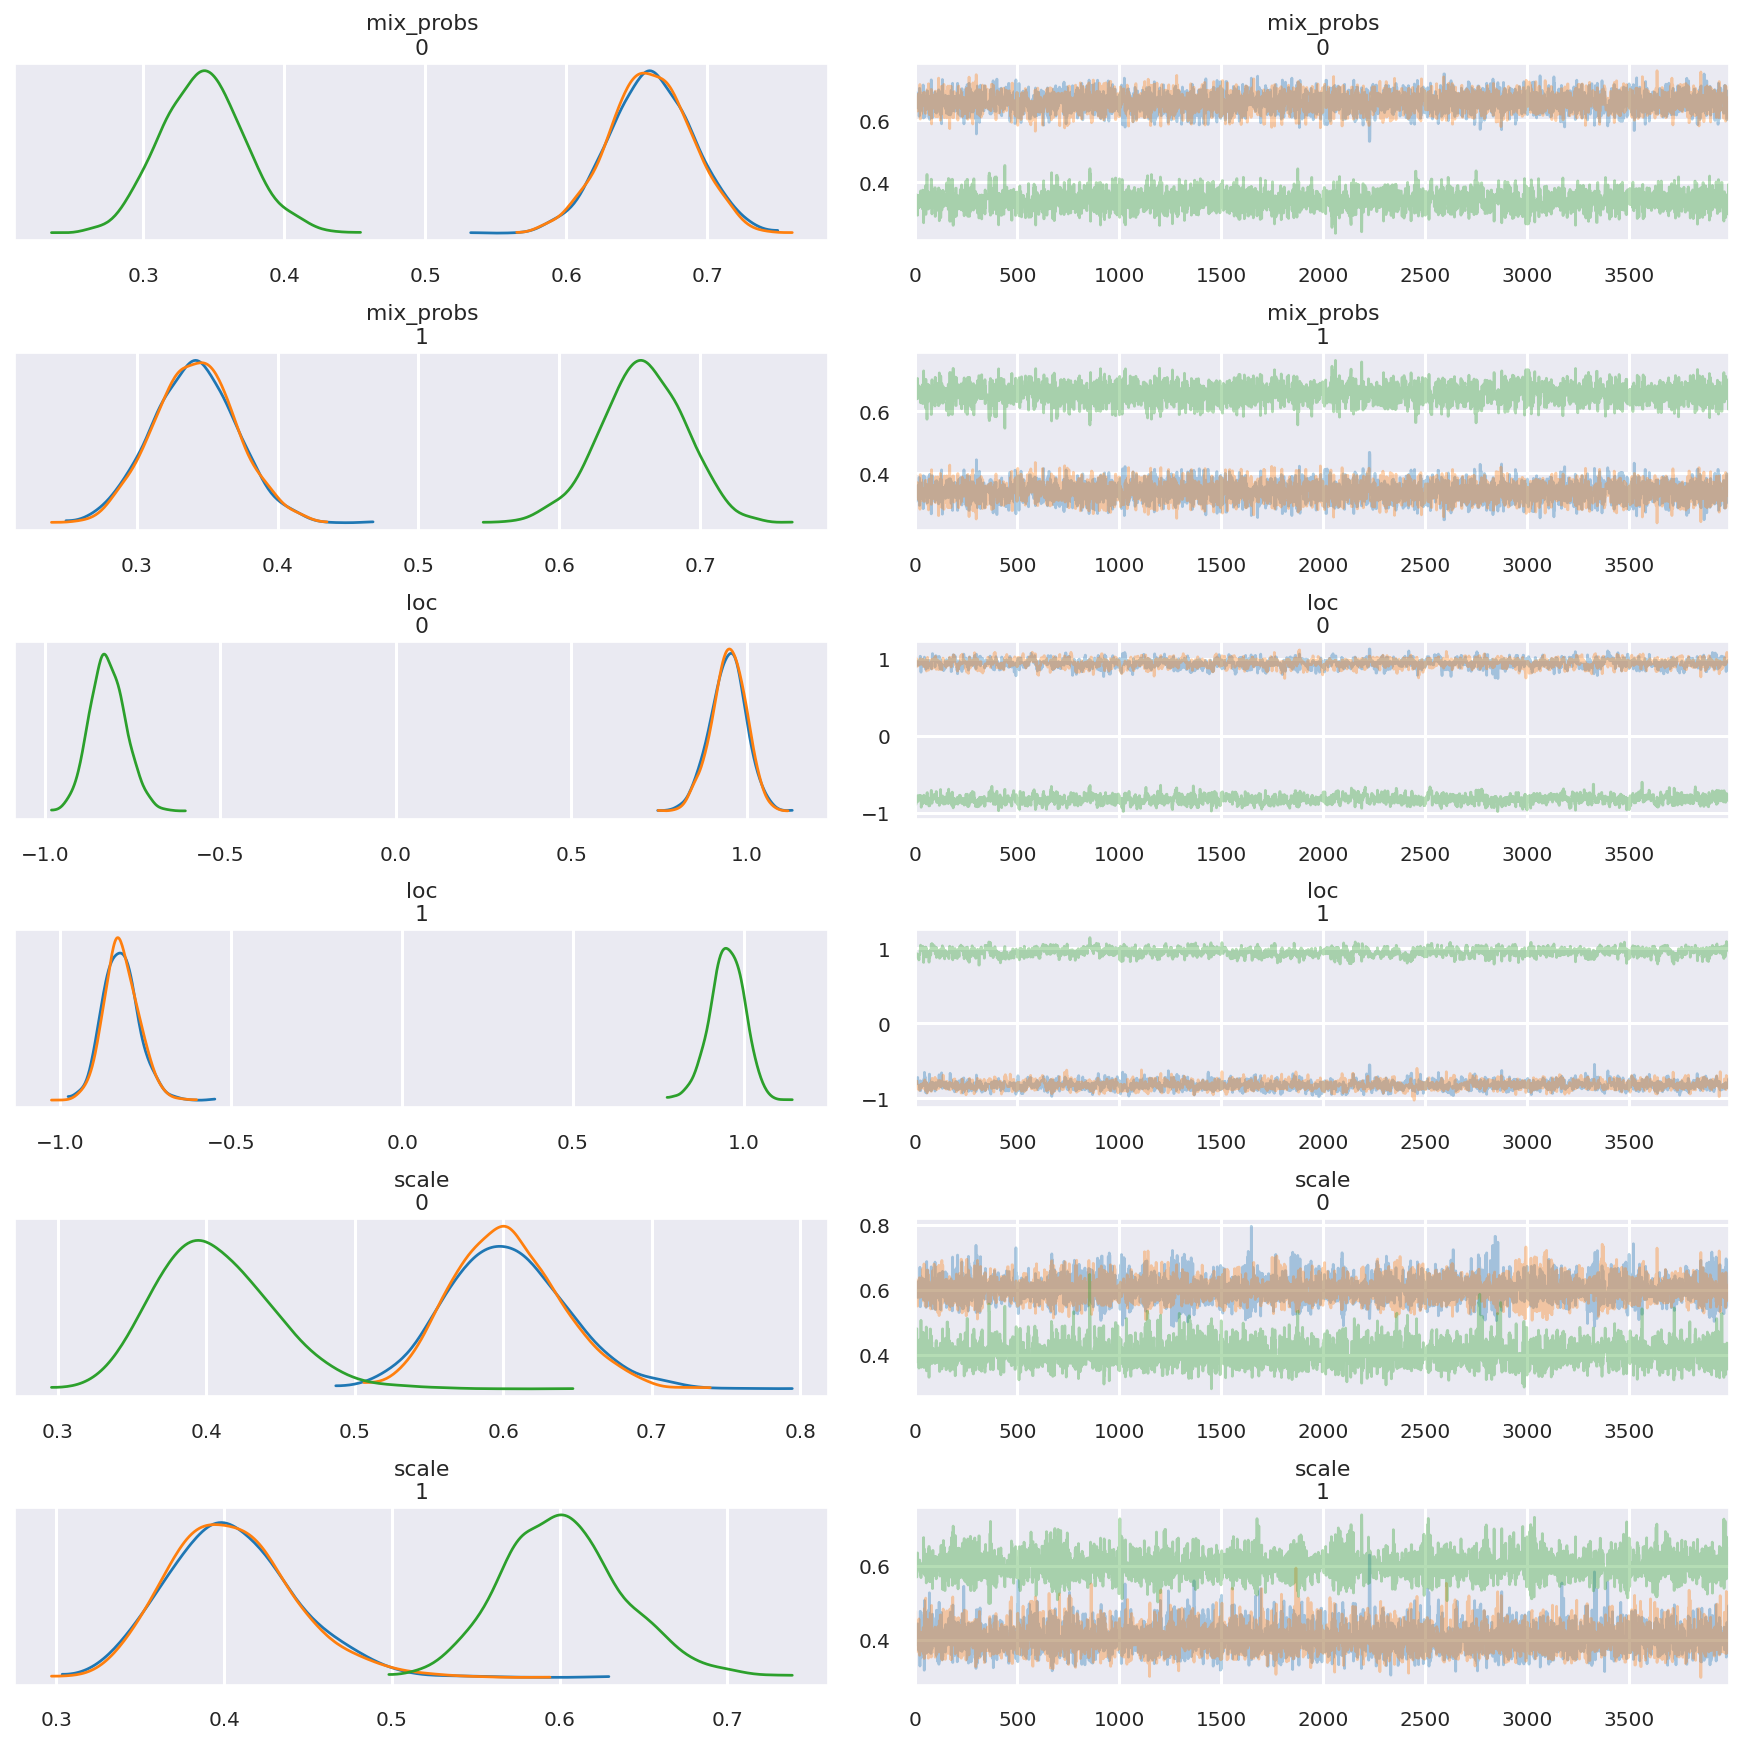

In [ ]:
var_name = ['mix_probs', 'loc', 'scale']
trace = format_trace(states, var_name, chain_dim=1)
az.plot_trace(trace)

上記のコードを何回か実行してみると分かりますが、chiainによりパラメータの推定値が大きく異なってしまうことがあります。  
今回のデータは2つのグループに分かれていますが、１番目、２番目のパラメータがそれぞれどちらのグループを表すかについては必然性がないので、chainにより入れ替わってしまうことがあるためです（label switching）。  
そこで今回は1つのchainのみ用いて、パラメータの推定値を求めてみます。

In [ ]:
# 1つ目のchainだけ取り出す
trace = format_trace([s[:, 0, :] for s in states], var_name)
az.summary(trace)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mix_probs[0],0.660,0.030,0.603,0.714,0.001,0.000,2236.0,2236.0,2263.0,2049.0,NaN
mix_probs[1],0.340,0.030,0.286,0.397,0.001,0.000,2236.0,2210.0,2263.0,2049.0,NaN
loc[0],0.945,0.051,0.845,1.038,0.002,0.002,484.0,481.0,480.0,1189.0,NaN
loc[1],-0.824,0.052,-0.915,-0.724,0.002,0.001,679.0,672.0,669.0,1268.0,NaN
scale[0],0.602,0.040,0.530,0.678,0.001,0.000,3923.0,3832.0,3904.0,854.0,NaN
scale[1],0.404,0.038,0.339,0.478,0.001,0.001,2495.0,2334.0,2790.0,2191.0,NaN


# 参考リンク
- https://www.tensorflow.org/probability/examples/Understanding_TensorFlow_Distributions_Shapes  
- https://www.tensorflow.org/probability/examples/Bayesian_Switchpoint_Analysis
- https://speakerdeck.com/katsuragi/tensorflow-probability-dehazimeru-que-lu-de-puroguraminguru-men  
